#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##[TO COMPLETE] Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [ ]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [ ]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###[TO COMPLETE] Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

[TO COMPLETE] In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

Since it is binary classification, we use binary crossentropy.
I use sigmoid because it's a binary classification problem.
it will give me 0 or 1 

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                1376      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 31s 149ms/step - loss: 0.6910 - accuracy: 0.5259 - val_loss: 0.6637 - val_accuracy: 0.6249
Epoch 2/10
196/196 [==============================] - 27s 140ms/step - loss: 0.6030 - accuracy: 0.7081 - val_loss: 0.4920 - val_accuracy: 0.7766
Epoch 3/10
196/196 [==============================] - 28s 142ms/step - loss: 0.3897 - accuracy: 0.8342 - val_loss: 0.4254 - val_accuracy: 0.8122
Epoch 4/10
196/196 [==============================] - 27s 140ms/step - loss: 0.2803 - accuracy: 0.8882 - val_loss: 0.4326 - val_accuracy: 0.8054
Epoch 5/10
196/196 [==============================] - 28s 142ms/step - loss: 0.1976 - accuracy: 0.9293 - val_loss: 0.4164 - val_accuracy: 0.8363
Epoch 6/10
196/196 [==============================] - 28s 143ms/step - loss: 0.1207 - accuracy: 0.9614 - val_loss: 0.4500 - val_accuracy: 0.8382
Epoch 7/10
196/196 [==============================] - 28s 143ms/step - loss: 0.0708 - accuracy: 0.9809 - val_loss: 0.5382 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 7s - loss: 0.6518 - accuracy: 0.8208
accuracy: 82.08%


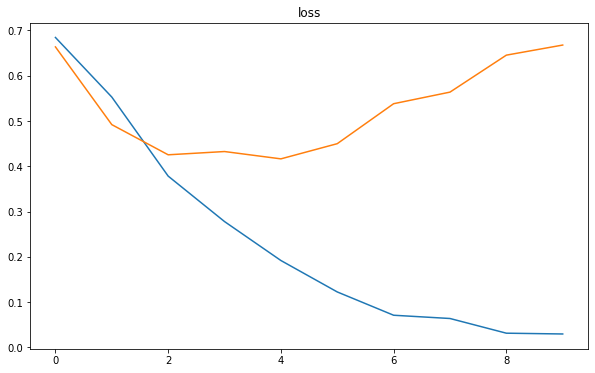

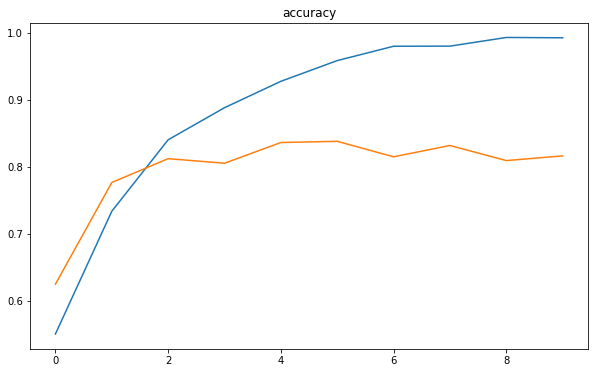

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion immediately after this cell*

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 13)                1248      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 14        
Total params: 101,262
Trainable params: 101,262
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 42s 253ms/step - loss: 0.6431 - accuracy: 0.6336 - val_loss: 0.3740 - val_accuracy: 0.8576
Epoch 2/10
157/157 [==============================] - 40s 254ms/step - loss: 0.3291 - accuracy: 0.8843 - val_loss: 0.3132 - val_accuracy: 0.8796
Epoch 3/10
157/157 [==============================] - 41s 264ms/step - loss: 0.2422 - ac

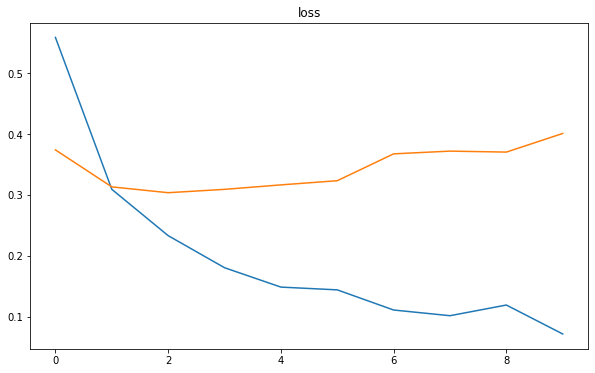

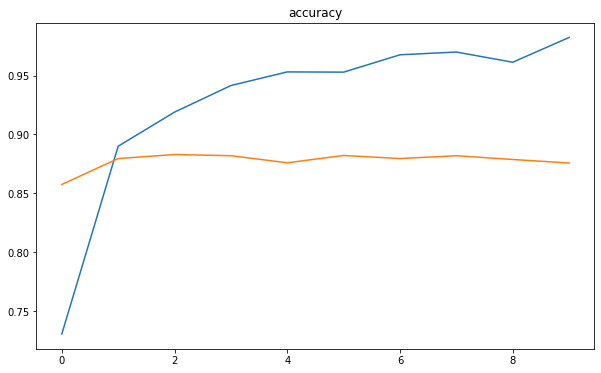

In [ ]:
model_lstm = keras.models.Sequential()
model_lstm.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_lstm.add(keras.layers.LSTM(13)) 
model_lstm.add(keras.layers.Dense(1, activation="sigmoid"))

model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])




####################################################################################ù
#evalutation
model_lstm.summary()
history = model_lstm.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)
plot_loss(history)
plot_accuracy(history)
scores = model_lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_lstm.metrics_names[1], scores[1]*100))

Gru


In [ ]:
#gru model 
model_gru = keras.models.Sequential()
model_gru.add(keras.layers.Embedding(input_dim=num_words, output_dim=10)) 

#16 filters
model_gru.add(keras.layers.GRU(16))
model_gru.add(keras.layers.Dense(1, activation="sigmoid"))

model_gru.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


######################################################################
#evaluation
model_gru.summary()
history = model_gru.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)
scores = model_gru.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_gru.metrics_names[1], scores[1]*100))



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru (GRU)                    (None, 16)                1344      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 39s 237ms/step - loss: 0.6702 - accuracy: 0.5741 - val_loss: 0.3946 - val_accuracy: 0.8280
Epoch 2/10
157/157 [==============================] - 39s 250ms/step - loss: 0.3245 - accuracy: 0.8673 - val_loss: 0.3243 - val_accuracy: 0.8692
Epoch 3/10
157/157 [==============================] - 40s 257ms/step - loss: 0.2445 - ac

parameters:
- Simple RNN : 101,409 trainable parameters
- LSTM : Using 13(1,248 parameters),i obtain a model with a total of 101,262 trainable parameters.
-GRU 16 (1,344 parameters) for GRU, i obtain a model with a total of 101,361 trainable parameters. 
________________________________________________
Accuracy:
- LSTM and GRU have better performance than the original.
-Simple RNN: Accuracy: 0.82 | loss: 0.65
-LSTM      : Accuracy: 0.861 | loss: 0.43
-GRU       : Accuracy: 0.852 | loss: 0.47
________________________________________________
Training time:
- LSTM" and "GRU" have been much slower than "SimpleRNN" ( in my system)
-They require about 1 min for each epoche



##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 92s 567ms/step - loss: 0.6595 - accuracy: 0.5730 - val_loss: 0.4087 - val_accuracy: 0.8422
Epoch 2/10
157/157 [==============================] - 88s 559ms/step - loss: 0.3367 - accuracy: 0.8655 - val_loss: 0.3099 - val_accuracy: 0.8718
Epoch 3/10
157/157 [==============================] - 87s 556ms/step - loss: 0.3003 - ac

391/391 - 20s - loss: 0.5850 - accuracy: 0.8153
accuracy: 81.53%


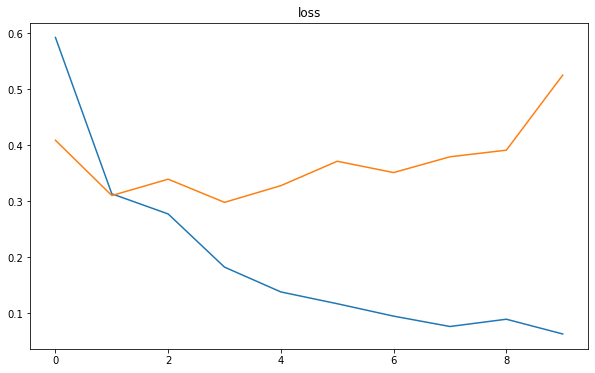

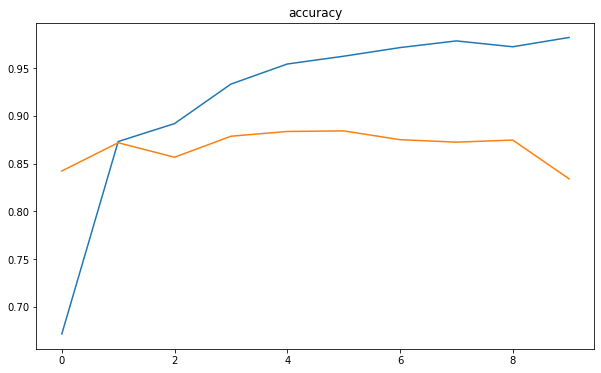

In [ ]:
plot_loss(history)
plot_accuracy(history)
scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**[TO COMPLETE]**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

**[TO COMPLETE]** Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion immediately after this cell*

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
dropout (Dropout)            (None, None, 10)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                3456      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 103,489
Trainable params: 103,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
79/79 [==============================] - 50s 589ms/step - loss: 0.6913 - accuracy: 0.5223 - val_loss: 0.6182 - val_accuracy: 0.6726
Epoch 2/10
79/79 [==============================] - 45s 568ms/step - loss: 0.5821 - accuracy: 0.7198 - 

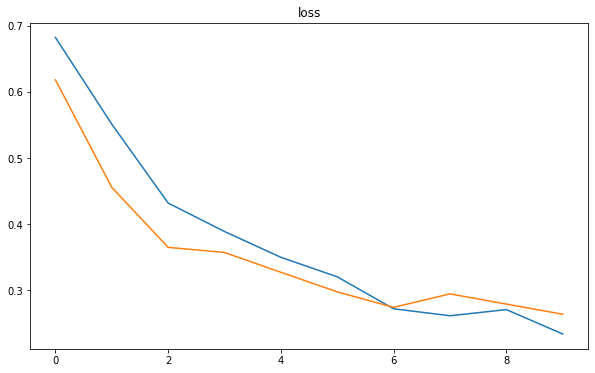

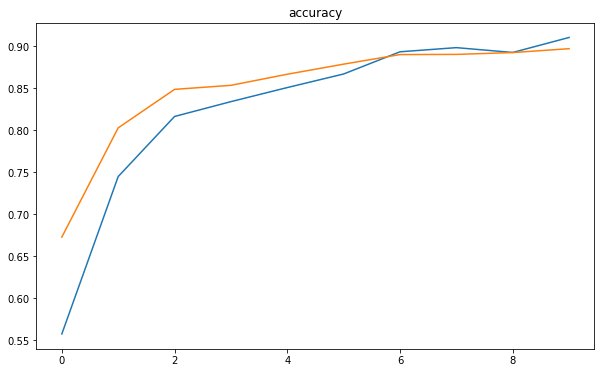

In [ ]:
original_batch_size = 128
original_epochs = 10

improved_model_bidirectional = keras.models.Sequential()
improved_model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
improved_model_bidirectional.add(keras.layers.Dropout(0.8)) #change to 0.8
improved_model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(16)))
improved_model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

improved_model_bidirectional.compile(loss="binary_crossentropy",
                                     optimizer=keras.optimizers.Adam(learning_rate=0.001),
                                     metrics=["accuracy"])

improved_model_bidirectional.summary()

improved_history = improved_model_bidirectional.fit(X_train_trim, y_train, epochs=int(original_epochs), batch_size=int(original_batch_size*2), validation_split=0.2)
plot_loss(improved_history)

plot_accuracy(improved_history)

scores = improved_model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (improved_model_bidirectional.metrics_names[1], scores[1]*100))

- The orignal bidirectional model gives bad perfomarnce and it overfits pretty much.

- Putting dropout on the input side and setting it with a very high probablity (0.8) cause improvement of performance . The probably reason is due the input side: the feature are too many 

- Since the main cause of overfitting is due the  high number of parameter in the model(compared with the number of training examples),dropping the number of LSTM from 32 to 16,the final performance  increases. 

- After many attemps, doubling the batch size,the performance increase a bit.